## 1. Mount the Drive

In [ ]:
#Connect google drive folder with images
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

## 2. Install Modules

In [ ]:
#Tensorflow and keras
import tensorflow as tf
import keras
import tensorflow_datasets as tfds

#Set random seed
tf.random.set_seed(0)

#General modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, pathlib
import cv2
import seaborn as sns
from sklearn.datasets import make_blobs
import random

#Load the directory
from skimage.transform import resize
from skimage.io import imread

#Train & test
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn import metrics

#Train & test - baseline model
from sklearn.dummy import DummyClassifier

#Train & test - trees & random forests
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

#Train & test - support vector machine
from sklearn import svm, datasets

#Train & test - convolutional neural network
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers 
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

#SVM Visualisation
from sklearn.decomposition import PCA

## 3. Load the Directory

In [ ]:
#Connect to the directory
plasticimagedir = '/content/drive/MyDrive/Plastic_images_dir'
os.chdir(plasticimagedir)
!ls

augmented_classifier.png    LDPE		      PVC
checkpoint_path2.keras	    mobilenet_classifier.png  resnet_classifier.png
checkpoint_path.keras	    model_ensemble.pkl	      saved_model
cnn_classifier.png	    OTHER		      simple_classifier.png
efficientb7_classifier.png  PET
HDPE			    PP


## 4. Visualise the Data

In [ ]:
#Code adapted from tensorflow guides
#Load image directory
dataset = tf.keras.utils.image_dataset_from_directory(
    plasticimagedir,
    shuffle = True,
    seed=123,
    image_size = (224, 224),
    batch_size = 32
)

#Get the class names using the class_names attribute on the dataset
class_names = dataset.class_names
print(class_names)

Found 3195 files belonging to 6 classes.
['HDPE', 'LDPE', 'OTHER', 'PET', 'PP', 'PVC']


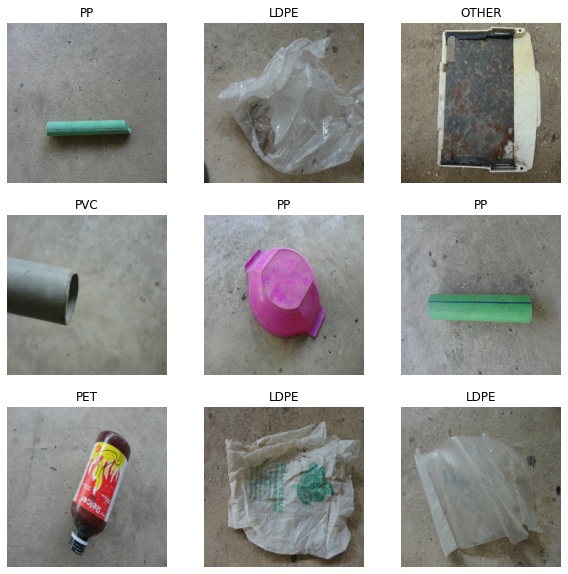

In [ ]:
#Code adapted from tensorflow guides
#Visualise the first 9 images in the dataset
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#Check the number of axes of the image tensor, using the ndim attribute. It should display 4 as images are Rank-4 tensors.
imagesndim = images.ndim
print("Axes:", imagesndim)

#Check the shape of the image (samples in the batch, height, width, channels)
imagesshape = images.shape
print("Tensor shape:", imagesshape)

Axes: 4
Tensor shape: (32, 224, 224, 3)


## 5. Pre-Process the Data

In [ ]:
#Categories of plastic types 
Categories=['HDPE', 'LDPE', 'OTHER', 'PET', 'PP', 'PVC']

#Image size
IMG_SIZE = 64

In [ ]:
#Code adapted from the following sources:
#1. https://www.kaggle.com/code/ashutoshvarma/image-classification-using-svm-92-accuracy
#2. https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01

dataset_arr=[] #input array

#Loop through the categories
for i in Categories:
    print(f'loading... {i}') #display message to show that category is loading
    path=os.path.join(plasticimagedir,i) #join to the image directory
    class_index=Categories.index(i) #subdirectory name which is the inferred label
    class_len=len(os.listdir(path)) #get the number of files per category

    for img in os.listdir(path):
        try:
          img_array=cv2.imread(os.path.join(path,img))
          resized_array=cv2.resize(img_array,(IMG_SIZE, IMG_SIZE)) #resize images
          dataset_arr.append([resized_array,class_index])
        except Exception as e:
          pass
    print(f'loaded {i} successfully:', class_len) #display message to show that category has been loaded successfully

loading... HDPE
loaded HDPE successfully: 520
loading... LDPE
loaded LDPE successfully: 516
loading... OTHER
loaded OTHER successfully: 502
loading... PET
loaded PET successfully: 544
loading... PP
loaded PP successfully: 573
loading... PVC
loaded PVC successfully: 540


Below we will create three arrays
1. one to store the image data without edits (this will be used for CNN)
2. the second to store image data which has been reshaped and resized (for the other algorithms)
3. the third will store the image labels

In [ ]:
#Shuffle the dataset
random.shuffle(dataset_arr)

In [ ]:
#Show the length of the newly created dataset array
lenofimage = len(dataset_arr)

X=[] #array to store the untouched image data for neural network usage 
X_2=[] #array to store the normalised and reshaped image data
y=[] #array to store the labels
lenofimage = len(dataset_arr)

#loop through the dataset array, and save the image data and labels into separate arrays
#remember in the intial for loop, we saved both the resized array and labels into the dataset array
for imgdata, label in dataset_arr:
    X.append(imgdata)
    y.append(label)

#X and y arrays
y=np.array(y)
X= np.array(X)

#Reshape the array - X_2 should now be a Rank-2 tensor (matrix) 
# sklearn expects a 2D array as input to the fit() function which will be called on the model during training., the second being height*width*channels
X_2= np.array(X).reshape(lenofimage,-1)

#Normalise the array - maintain the pixels of all the images within a uniform range.
X_2 = X_2/255.0

#Display the X, X_2 and y arrays
print(y.shape)
print(X.shape)
print(X_2.shape)

(3195,)
(3195, 64, 64, 3)
(3195, 12288)


##6. Split the Dataset

In [ ]:
#split the dataset for baseline data, SVMs, random forests
X_train_1,X_test_1,y_train_1,y_test_1=train_test_split(X_2,y,test_size=0.20,random_state=77)

## encode with the convenient to_categorical function
train_labels = to_categorical(y)

#split the dataset for CNN
X_train_2,X_test_2,y_train_2,y_test_2=train_test_split(X,train_labels,test_size=0.20,random_state=77)

##7. Train and Test the Baseline Model

In [ ]:
#guidance from: https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
#train the dataset using the Dummy Classifier
#“uniform”: generates predictions uniformly at random from the list of unique classes observed in y, i.e. each class has equal probability.
dummy_clf = DummyClassifier(strategy="uniform", random_state=123)

#fit the dataset to the Dummy Classifier
dummy_clf.fit(X_train_1, y_train_1)

#test the dataset with the Dummy Classifier
y_pred_1 = dummy_clf.predict(X_test_1)

In [ ]:
#print the classification report
print(classification_report(y_pred_1,y_test_1))

              precision    recall  f1-score   support

           0       0.17      0.15      0.16       104
           1       0.16      0.14      0.15       117
           2       0.07      0.06      0.07        97
           3       0.15      0.16      0.15       113
           4       0.21      0.25      0.23        99
           5       0.17      0.19      0.18       109

    accuracy                           0.16       639
   macro avg       0.16      0.16      0.16       639
weighted avg       0.16      0.16      0.16       639



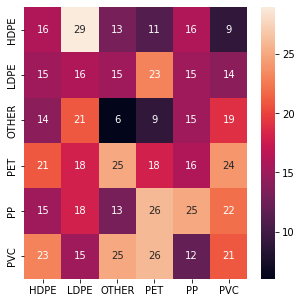

In [ ]:
#print the confusion matrix as an image
confmat_1 = confusion_matrix(y_test_1, y_pred_1)
classes = Categories

#put the confusion matrix into a dataframe
df_confmat_1 = pd.DataFrame(confmat_1, index = classes, columns = classes)

#plot the confusion matrix using a heatmap
plt.figure(figsize = (5,5))
confmat_plot_1 = sns.heatmap(df_confmat_1, annot=True)

## 8. Train and Test the Random Forest

In [ ]:
#Guidance from: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#Train the data using RandomForestClassifier
modelone = RandomForestClassifier(random_state = 0, n_estimators = 170, min_samples_split = 7, criterion="entropy",
                                  min_samples_leaf = 7, max_features = "sqrt")

#Fit the data
modelone.fit(X_train_1, y_train_1)

#Test the dataset using the RandomForestClassifier
y_pred_rf = modelone.predict(X_test_1)

In [ ]:
#print the classification report
print(classification_report(y_pred_rf,y_test_1, target_names=Categories))

              precision    recall  f1-score   support

        HDPE       0.61      0.61      0.61        94
        LDPE       0.70      0.68      0.69       102
       OTHER       0.67      0.62      0.64        91
         PET       0.51      0.60      0.55       104
          PP       0.73      0.69      0.71       126
         PVC       0.70      0.70      0.70       122

    accuracy                           0.65       639
   macro avg       0.65      0.65      0.65       639
weighted avg       0.66      0.65      0.65       639



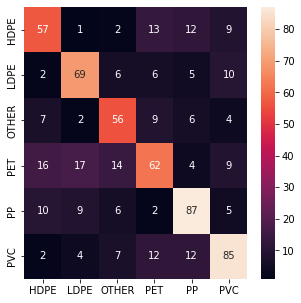

In [ ]:
#print the confusion matrix as an image
confmat_3 = confusion_matrix(y_test_1, y_pred_rf)
classes = Categories

#put the confusion matrix into a dataframe
df_confmat_3 = pd.DataFrame(confmat_3, index = classes, columns = classes)

#plot the confusion matrix using a heatmap
plt.figure(figsize = (5,5))
confmat_plot_3 = sns.heatmap(df_confmat_3, annot=True)

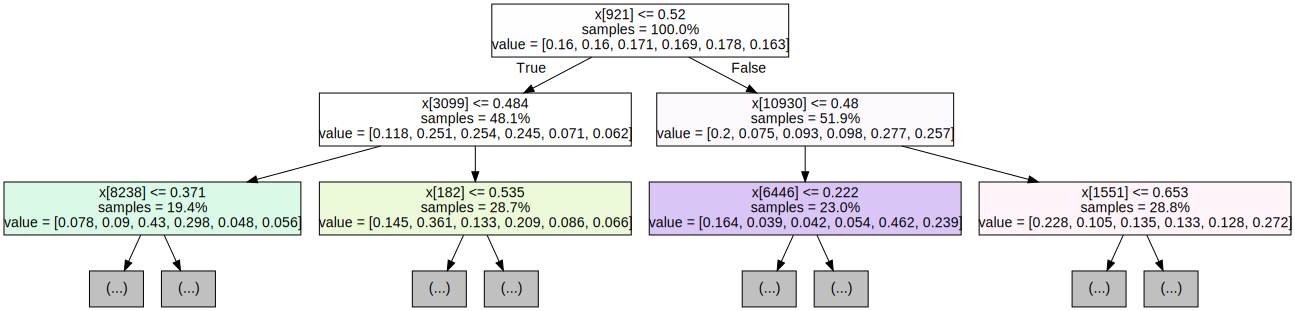

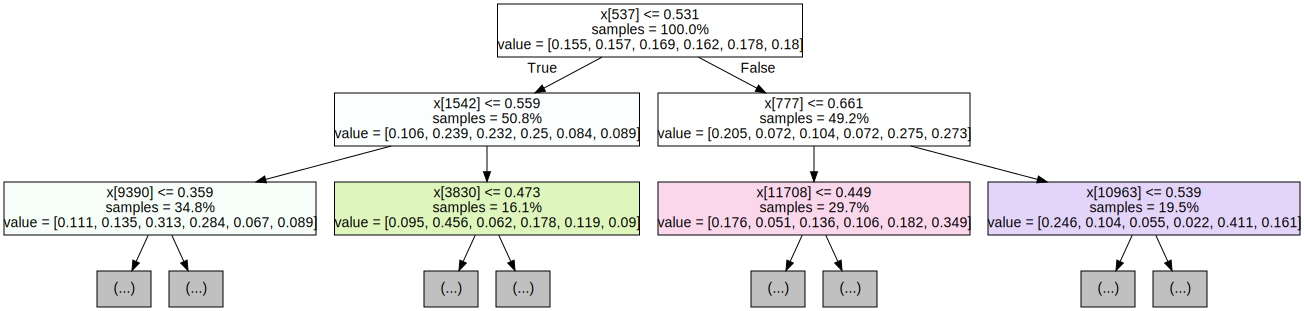

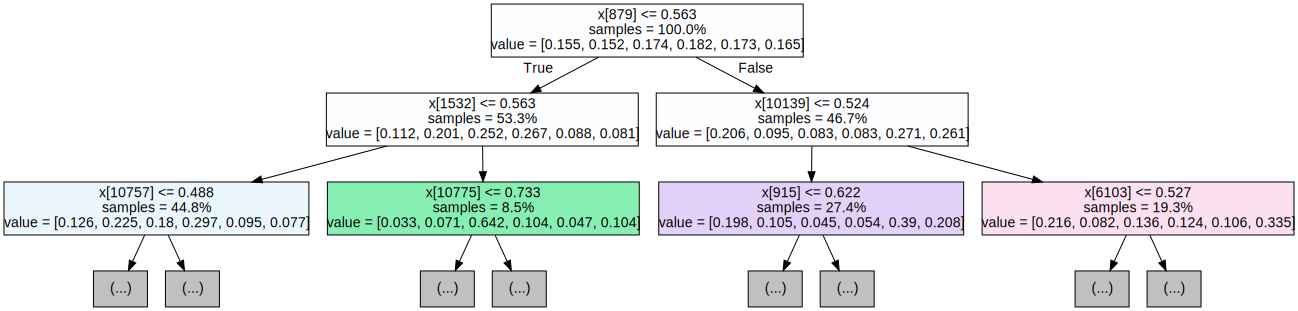

In [ ]:
# Export the first three decision trees from the forest
# Code adapted from: https://www.datacamp.com/tutorial/random-forests-classifier-python
for i in range(3):
    tree = modelone.estimators_[i]
    dot_data = export_graphviz(tree,
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## 9. Train and Test the Support Vector Machine

In [ ]:
#Create a support vector classifier
#Train the data using Support Vector Machine
modeltwo = svm.SVC(C = 10, gamma = 0.001, kernel = 'rbf', probability=True) #True = applies expensive Platt's calibration internally
#Fit the data
modeltwo.fit(X_train_1, y_train_1)

#Test the dataset using the RandomForestClassifier
y_pred_svm = modeltwo.predict(X_test_1)

In [ ]:
#print the classification report
print(classification_report(y_pred_svm,y_test_1, target_names=Categories))

              precision    recall  f1-score   support

        HDPE       0.73      0.61      0.67       113
        LDPE       0.70      0.70      0.70        99
       OTHER       0.63      0.65      0.64        82
         PET       0.62      0.65      0.64       117
          PP       0.77      0.72      0.74       128
         PVC       0.70      0.86      0.77       100

    accuracy                           0.70       639
   macro avg       0.70      0.70      0.69       639
weighted avg       0.70      0.70      0.70       639



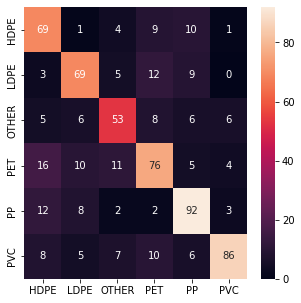

In [ ]:
#print the confusion matrix as an image
confmat_4 = confusion_matrix(y_test_1, y_pred_svm)
classes = Categories

#put the confusion matrix into a dataframe
df_confmat_4 = pd.DataFrame(confmat_4, index = classes, columns = classes)

#plot the confusion matrix using a heatmap
plt.figure(figsize = (5,5))
confmat_plot_4 = sns.heatmap(df_confmat_4, annot=True)

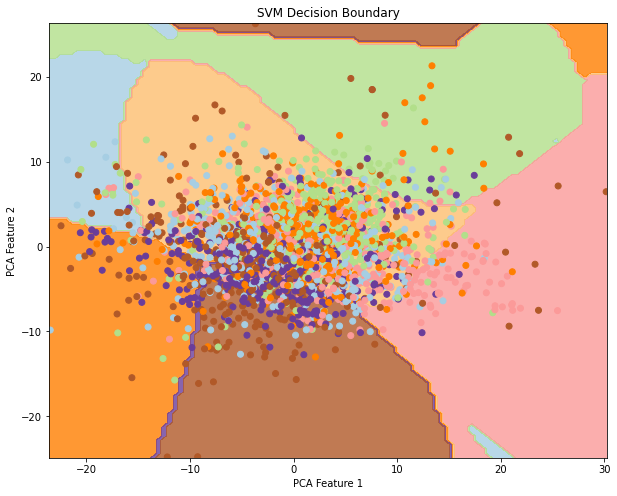

In [ ]:
# Perform PCA on the image data to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_1)

# Create a mesh grid of points that cover the range of feature values in the PCA-transformed data
x_min, x_max = X_pca[:, 0].min() - 0.1, X_pca[:, 0].max() + 0.1
y_min, y_max = X_pca[:, 1].min() - 0.1, X_pca[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Use the trained SVM model to predict the class labels of each point in the mesh grid
Z = modeltwo.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Plot the decision boundary and training data points
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_1, cmap=plt.cm.Paired)
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('SVM Decision Boundary')
plt.show()

## 10. Train and Test the Convolutional Neural Network

In [ ]:
#Code adapted from deep learning with python, page 189
#Below we are using the Callback argument, which will be passed to the fit method

#Callbacks - Early Stopping
callbacks_list = [
#Callbacks - Model Checkpoint
  #Saves the current weights after each epoch
  keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_pathfinal.keras",
    monitor="loss",
    save_best_only=True,
  )
]

In [ ]:
#Extracts all features from the pre-trained model except the last layer
feature_extractor_model = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_160/feature_vector/5" #mobilenet

#trainable = false freezes all layers except the last
pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model, trainable=True, 
                                                      arguments=dict(batch_norm_momentum=0.997), input_shape=(64, 64, 3))

In [ ]:
#Train the model using the pre-trained model
modelthree = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(6, activation="softmax")
])

modelthree.build((None, 64, 64, 3))
modelthree.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1024)              3228864   
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 3,235,014
Trainable params: 3,213,126
Non-trainable params: 21,888
_________________________________________________________________


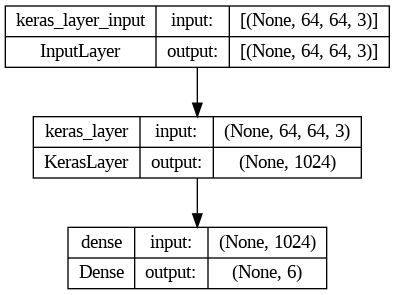

In [ ]:
#visualising the connectivity of the model/topology of the model
keras.utils.plot_model(modelthree, "mobilenet_classifier.png", show_shapes=True)

In [ ]:
#optimser, loss and metrics are trained at compilation
modelthree.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

#train the model on all the data
history = modelthree.fit(X_train_2, y_train_2, 
                         epochs=30, callbacks=callbacks_list)

Epoch 1/30
80/80 [==============================] - 53s 601ms/step - loss: 1.2486 - accuracy: 0.6342
Epoch 2/30
80/80 [==============================] - 49s 610ms/step - loss: 0.4343 - accuracy: 0.8893
Epoch 3/30
80/80 [==============================] - 49s 608ms/step - loss: 0.2528 - accuracy: 0.9601
Epoch 4/30
80/80 [==============================] - 48s 598ms/step - loss: 0.1899 - accuracy: 0.9828
Epoch 5/30
80/80 [==============================] - 50s 629ms/step - loss: 0.1648 - accuracy: 0.9871
Epoch 6/30
80/80 [==============================] - 49s 609ms/step - loss: 0.1578 - accuracy: 0.9902
Epoch 7/30
80/80 [==============================] - 48s 605ms/step - loss: 0.1454 - accuracy: 0.9941
Epoch 8/30
80/80 [==============================] - 48s 598ms/step - loss: 0.1439 - accuracy: 0.9941
Epoch 9/30
80/80 [==============================] - 49s 605ms/step - loss: 0.1422 - accuracy: 0.9949
Epoch 10/30
80/80 [==============================] - 49s 616ms/step - loss: 0.1326 - accura

In [ ]:
test_loss_two, test_acc_two = modelthree.evaluate(X_test_2, y_test_2)

20/20 [==============================] - 2s 67ms/step - loss: 0.6478 - accuracy: 0.8811


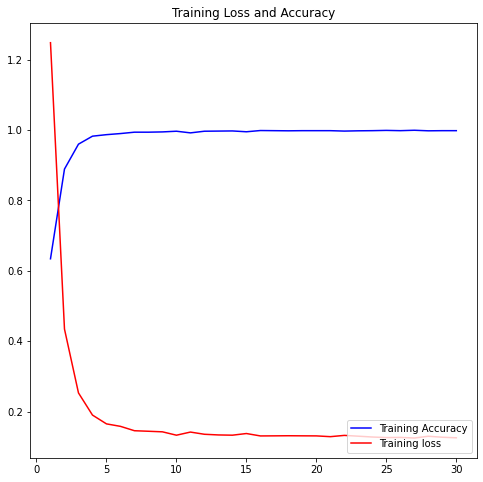

In [ ]:
#see the history of the training
history_dict = history.history

#plot the training loss
loss_values = history_dict['loss']

#plot the training accuracy
acc = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(8, 8))

plt.plot(epochs, acc, 'b', label='Training Accuracy') #bo is for blue dot
plt.plot(epochs, loss_values, 'r', label='Training loss') #bo is for blue dot

plt.legend(loc="lower right")
plt.title('Training Loss and Accuracy')

plt.show()

In [ ]:
#Code adapted from: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
#print classification report for CNN
preds_cnn = np.round(modelthree.predict(X_test_2), 0)

#print classification report
classification_metrics_cnn = metrics.classification_report(y_test_2, preds_cnn, target_names = Categories)
print(classification_metrics_cnn)

20/20 [==============================] - 2s 64ms/step
              precision    recall  f1-score   support

        HDPE       0.84      0.90      0.87        94
        LDPE       0.84      0.84      0.84        98
       OTHER       0.92      0.82      0.87        84
         PET       0.81      0.89      0.85       122
          PP       0.91      0.81      0.86       119
         PVC       0.98      0.99      0.99       122

   micro avg       0.88      0.88      0.88       639
   macro avg       0.88      0.87      0.88       639
weighted avg       0.89      0.88      0.88       639
 samples avg       0.88      0.88      0.88       639



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


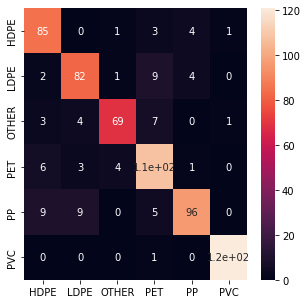

In [ ]:
#Categorical code adapted from: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
#Change into categorical variables
categorical_test_labels = pd.DataFrame(y_test_2).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds_cnn).idxmax(axis=1)

#print the confusion matrix as an image
confmat_5 = confusion_matrix(categorical_test_labels, categorical_preds)
classes = Categories

#put the confusion matrix into a dataframe
df_confmat_5 = pd.DataFrame(confmat_5, index = classes, columns = classes)

#plot the confusion matrix using a heatmap
plt.figure(figsize = (5,5))
confmat_plot_5 = sns.heatmap(df_confmat_5, annot=True)

## 11. Assemble the Ensemble Model

In [ ]:
#weights for each model
svm_weight = 0.2
rf_weight = 0.1
cnn_weight = 0.7

# Get predictions from individual models
rf_pred = modelone.predict_proba(X_test_1).reshape(-1, 6)
svm_pred = modeltwo.predict_proba(X_test_1).reshape(-1, 6)
cnn_pred = modelthree.predict(X_test_2).reshape(-1, 6)

# Combine the predictions using weighted averaging
ensemble_preds = (svm_weight * svm_pred) + \
                 (rf_weight * rf_pred) + \
                 (cnn_weight * cnn_pred)

# Make final predictions by taking the argmax
final_preds = np.argmax(ensemble_preds, axis=1)

20/20 [==============================] - 1s 66ms/step


In [ ]:
#Individual predictions
print(rf_pred[1])
print(svm_pred[1])
print(cnn_pred[1])
print(ensemble_preds[1])

[0.07239139 0.09304259 0.21561356 0.47436811 0.03512141 0.10946293]
[0.00360762 0.00777374 0.13056492 0.82666552 0.00398673 0.02740146]
[2.6800395e-08 1.6183807e-07 1.3073732e-08 9.9999958e-01 1.9366486e-11
 7.0281118e-08]
[0.00796068 0.01085912 0.04767435 0.91276961 0.00430949 0.01642663]


In [ ]:
#Final predictions
final_preds

array([0, 3, 4, 3, 0, 4, 5, 4, 5, 2, 5, 4, 0, 5, 3, 2, 2, 3, 5, 3, 1, 1,
       5, 1, 1, 2, 5, 4, 5, 5, 5, 0, 0, 4, 0, 2, 3, 4, 3, 1, 3, 0, 2, 1,
       3, 1, 2, 5, 4, 1, 5, 5, 1, 3, 3, 2, 5, 2, 1, 5, 3, 5, 3, 1, 4, 2,
       0, 0, 2, 3, 4, 3, 4, 0, 2, 2, 0, 2, 2, 3, 4, 5, 1, 4, 3, 5, 0, 3,
       5, 5, 0, 4, 3, 3, 5, 4, 0, 2, 0, 5, 3, 4, 1, 0, 4, 0, 4, 4, 5, 1,
       0, 3, 0, 0, 3, 3, 1, 0, 2, 3, 4, 1, 5, 0, 3, 3, 2, 2, 0, 4, 3, 0,
       5, 1, 5, 1, 1, 3, 3, 5, 5, 1, 5, 2, 2, 4, 1, 3, 5, 0, 1, 0, 5, 3,
       0, 0, 2, 3, 5, 1, 3, 0, 4, 2, 2, 5, 0, 4, 4, 3, 5, 4, 3, 4, 4, 0,
       1, 0, 5, 2, 2, 0, 1, 5, 5, 4, 2, 3, 5, 5, 4, 5, 0, 3, 4, 2, 3, 5,
       3, 4, 5, 3, 4, 3, 3, 4, 3, 4, 5, 0, 1, 2, 5, 1, 3, 3, 3, 2, 1, 4,
       0, 3, 1, 2, 0, 1, 0, 4, 3, 4, 1, 1, 5, 0, 3, 3, 5, 3, 4, 4, 1, 1,
       1, 3, 0, 3, 0, 1, 5, 4, 3, 3, 2, 4, 4, 0, 2, 5, 1, 2, 5, 0, 1, 3,
       5, 0, 2, 3, 5, 1, 2, 3, 5, 5, 5, 5, 3, 1, 5, 3, 5, 4, 3, 1, 4, 1,
       3, 0, 1, 3, 2, 2, 0, 1, 4, 4, 0, 1, 3, 1, 1,

In [ ]:
# Evaluate the performance of the ensemble model
accuracy = accuracy_score(y_test_1, final_preds)
print(accuracy)

0.8826291079812206


In [ ]:
print(classification_report(final_preds,y_test_1, target_names=Categories))

              precision    recall  f1-score   support

        HDPE       0.89      0.84      0.87       100
        LDPE       0.86      0.84      0.85       100
       OTHER       0.82      0.93      0.87        74
         PET       0.89      0.81      0.84       134
          PP       0.82      0.91      0.86       108
         PVC       0.99      0.98      0.99       123

    accuracy                           0.88       639
   macro avg       0.88      0.88      0.88       639
weighted avg       0.88      0.88      0.88       639



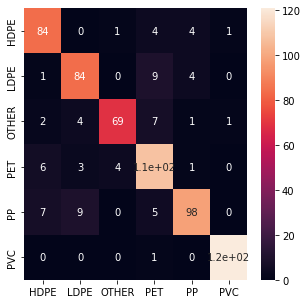

In [ ]:
#print the confusion matrix as an image
confmat_ensemble = confusion_matrix(y_test_1, final_preds)
classes = Categories

#put the confusion matrix into a dataframe
df_confmat_ensemble = pd.DataFrame(confmat_ensemble, index = classes, columns = classes)

#plot the confusion matrix using a heatmap
plt.figure(figsize = (5,5))
confmat_plot_ensemble = sns.heatmap(df_confmat_ensemble, annot=True)

In [ ]:
import pickle

# Save the model ensemble
with open('model_ensemble.pkl', 'wb') as f:
    pickle.dump((svm_weight, rf_weight, cnn_weight, modelone, modeltwo, modelthree), f)

##12. Visualise the Predictions

In [ ]:
#Load image directory
dataset_2 = tf.keras.utils.image_dataset_from_directory(
    plasticimagedir,
    shuffle = True,
    seed=123,
    image_size = (64, 64),
    batch_size = 32
)

Found 3195 files belonging to 6 classes.


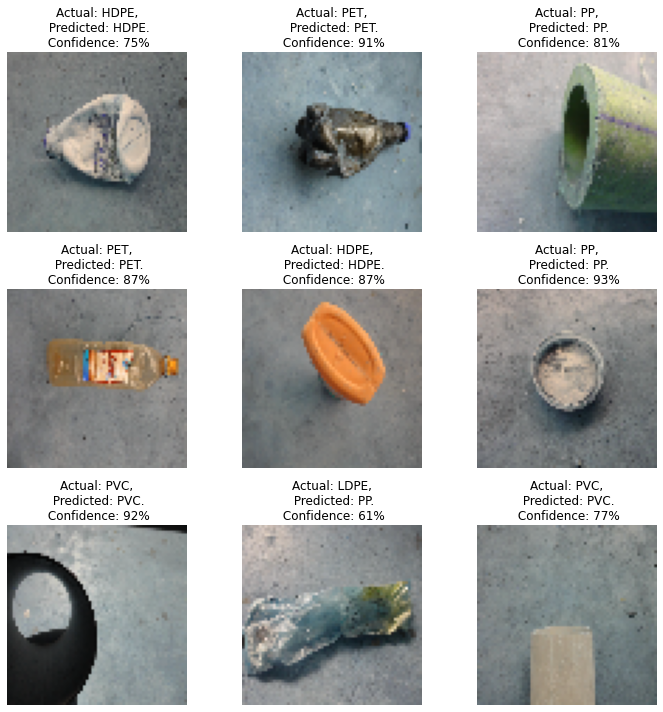

In [ ]:
#Adapted from tutorial: Deep learning project end to end | Potato Disease Classification
#Visualise 9 images from the dataset, with the actual label, predicted label, and confidence/likelihood of correctness
plt.figure(figsize=(10, 10))

for i in range(1):
    for j in range(9):
        idx = i*9 + j
        ax = plt.subplot(3, 3, j + 1)
        plt.imshow(X_test_2[idx].astype("uint8"))

        confidence = round(100 * np.max(ensemble_preds[idx]))
        predicted_class = class_names[final_preds[idx]]

        plt.title(f"Actual: {class_names[y_test_1[idx]]},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
    plt.tight_layout()
    plt.show()